In [255]:
using JuMP, Gurobi, LinearAlgebra, CSV, DataFrames, Pkg, Distances, Plots

In [262]:
centers = CSV.read("centers.csv", DataFrame, header=false);
centers2 = CSV.read("centers2.csv", DataFrame, header=false);
landfills = CSV.read("landfills.csv", DataFrame, header=false);
landfills2 = CSV.read("landfills2.csv", DataFrame, header=false);
q = CSV.read("q.csv", DataFrame, header=false);
q2 = CSV.read("q2.csv", DataFrame, header=false);
stations = CSV.read("stations.csv", DataFrame, header=false);
stations2 = CSV.read("stations2.csv", DataFrame, header=false);

In [263]:
first(centers, 5);

In [264]:
first(landfills, 5);

In [265]:
rename!(centers,:Column1 => "xco" );
rename!(centers,:Column2 => "yco" );
rename!(landfills,:Column1 => "xco" );
rename!(landfills,:Column2 => "yco" );
rename!(q,:Column1 => "waste" );
rename!(stations,:Column1 => "xco" );
rename!(stations,:Column2 => "yco" );

In [266]:
dmatx = pairwise(Euclidean(), centers.xco, landfills.xco);
dmaty = pairwise(Euclidean(), centers.yco, landfills.yco);
dmat = sqrt.((dmatx.^2)+(dmaty.^2));

# A.a

## The objective function is simply minimizing the overall distance that all waste is moved. In effect, it attempts to make the waste be disposed in the most efficient manner. This assumes that all waste transportation is equal and linear. In essence, there is no cost saving for moving waste in bulk. 

## Constraint 2 ensures that all the waste at centers is transported to a landfill.

## Using the big-M method, contraint 3 ensures that waste is only transported to those landfills which are built.

## Constraint 4 makes it so that only 5 landfills are built. 

## Constraint 5 makes it so that waste is a positive value. This assumes waste can only flow in one direction from a center to a landfill. 

## Constraint 6 makes it so that landfills are either fully built or not. This assumes that all landfills are the same size and serve the same functionality. 

# A.b

In [267]:
mod = JuMP.Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(),"MIPGap" => 0.0001))

set_optimizer_attribute(mod, "OutputFlag", 0) 

@variable(mod, z[j=1:15], Bin)
@variable(mod, x[i=1:50,j=1:15]>=0)

@constraint(mod, [i=1:50], sum(x[i,j] for j=1:15)== q[i,1])
@constraint(mod, [i=1:50, j=1:15], x[i,j] <= 1000000*z[j])
@constraint(mod, sum(z[j] for j=1:15)<=5)

@objective(mod, Min, sum(sum(dmat[i,j]*x[i,j] for j=1:15) for i=1:50))

optimize!(mod)

Academic license - for non-commercial use only - expires 2022-08-19


## The total distance traveled by the waste is 840,487.52

In [268]:
objective_value(mod)

840487.5240012797

In [269]:
x =  value.(x);

In [270]:
z1=value.(z)

15-element Vector{Float64}:
 -0.0
  0.0
  1.0
  1.0
 -0.0
 -0.0
  1.0
 -0.0
 -0.0
 -0.0
  0.0
  0.0
  1.0
  1.0
 -0.0

In [271]:
built_ind = [3,4,7,13,14];

## Landfills are built at the following coordinates:

In [272]:
lf_b = landfills[built_ind,:]

,xco,yco
,Float64,Float64
1,21.163,44.331
2,63.265,63.989
3,77.801,14.727
4,84.261,71.562
5,13.93,71.108


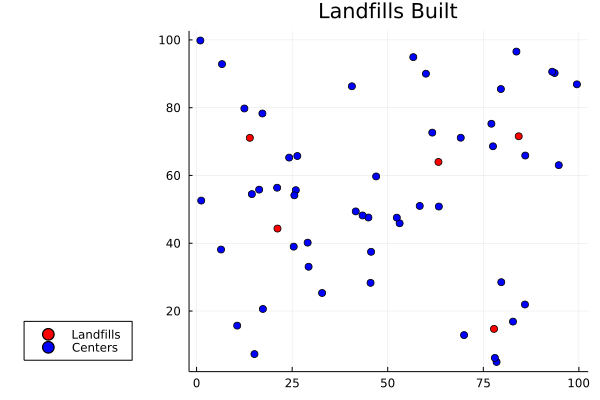

In [273]:
plot(lf_b.xco, lf_b.yco, seriestype = :scatter, color = "red", title = "Landfills Built",label = "Landfills", legend=:outerbottomleft)
plot!(centers.xco, centers.yco, seriestype = :scatter, color = "blue", label = "Centers")

# B

In [274]:
dmatx_ct = pairwise(Euclidean(), centers.xco, stations.xco);
dmaty_ct = pairwise(Euclidean(), centers.yco, stations.yco);
dmat_ct = sqrt.((dmatx_ct.^2)+(dmaty_ct.^2));

In [275]:
dmatx_tl = pairwise(Euclidean(), stations.xco, landfills.xco);
dmaty_tl = pairwise(Euclidean(), stations.yco, landfills.yco);
dmat_tl = sqrt.((dmatx_tl.^2)+(dmaty_tl.^2));

# B.c
# Formulation
## Sets
$i = 1,...,50$ centers 

$s = 1,...,50$ potential transfer stations 

$j = 1,...,15$ potential landfills

## Parameters 
 $q_i$ amount of waste generated at center $i$
 
 $d_{ij}$ (Euclidean) distance between center $i$ and potential landfill $j$
 
 $d_{is}$ (Euclidean) distance between center $i$ and transfer station $s$
 
 $d_{sj}$ (Euclidean) distance between transfer station $s$ and landfill $j$
 ## Variables 

 $z_j =1$ if landfill $j$ is built
 
 $t_s =1$ if transfer station $s$ is built
 
 $x_{ij}$ amount of waste transported from center $i$ to landfill $j$
 
 $a_{is}$ amount of waste transported from center $i$ to transfer center $s$
 
 $b_{sj}$ amount of compacted waste transported from transfer center $s$ to landfill $j$




### $$min_{z,x,ta,b} \quad \sum_{i=1}^{50}\sum_{j=1}^{15}d_{ij}x_{ij} + \sum_{i=1}^{50}\sum_{s=1}^{50}d_{is}a_{is} + \sum_{s=1}^{50}\sum_{j=1}^{15}d_{sj}b_{sj} + 1000\sum_{s=1}^{50}t_s$$
### $$x_{ij} \leq 1000000*z_j \quad \forall i,j$$  $$ \sum_{j=1}^{15}z_j \leq 5 $$ $$ \sum_{j=1}^{15} x_{ij} + \sum_{s=1}^{50} a_{is} = q_i  \quad \forall i$$ $$ \sum_{i=1}^{50} a_{is} = \sum_{j=1}^{15} b_{sj} \quad \forall i,s,j$$ $$ b_{sj} \leq 1000000*z_j \quad  \forall s,j$$  $$ \sum_{i=1}^{50} a_{is} \leq 2000t_s \quad  \forall i,s$$ $$x_{ij}, a_{is}, b_{sj} \leq 0 $$ $$z_j, t_s \in \{0,1\}  $$




In [276]:
mod2 = JuMP.Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(),"MIPGap" => 0.0001))

set_optimizer_attribute(mod2, "OutputFlag", 0) 

#OLD VARIABLES
#if landfill j is built
@variable(mod2, z[j=1:15], Bin)
#amount of waste transported from center i to landfill j
@variable(mod2, x[i=1:50,j=1:15]>=0)

#NEW VARIABLES
#if transfer station s is built
@variable(mod2, t[s=1:50], Bin)
#amount of waste transported from center i to trasnfer station s
@variable(mod2, a[i=1:50,s=1:50]>=0)
#amount of waste transported from center i to trasnfer station s
@variable(mod2, b[s=1:50,j=1:15]>=0)

#OLD CONSTRAINTS
#@constraint(mod2, [i=1:50], sum(x[i,j] for j=1:15)== q[i,1]) modified for reformulation
@constraint(mod2, [i=1:50, j=1:15], x[i,j] <= 1000000*z[j])
@constraint(mod2, sum(z[j] for j=1:15)<=5)

#NEW CONSTRAINTS
#ensure that all waste is taken care of
@constraint(mod2, [i=1:50], sum(x[i,j] for j=1:15) + sum(a[i,s] for s=1:50) == q[i,1]) 
#conservation of flow for transfer stations
@constraint(mod2, [i=1:50, s=1:50, j=1:15], sum(a[i,s] for i=1:50)==sum(b[s,j] for j=1:15))
#transfer station t cannot serve landfill j unless landfill j is built
@constraint(mod2, [s=1:50, j=1:15], b[s,j] <= 1000000*z[j])
@constraint(mod2, [i=1:50, s=1:50], sum(a[i,s] for i=1:50)<=2000*t[s])



@objective(mod2, Min, sum(dmat[i,j]*x[i,j] for i = 1:50, j = 1:15)
                +    sum(dmat_ct[i,s]*a[i,s] for i = 1:50, s = 1:50)
                +    sum(dmat_tl[s,j]*b[s,j] for s = 1:50, j = 1:15)/2
                +    sum(10000*t[s] for s=1:50))

optimize!(mod2)

Academic license - for non-commercial use only - expires 2022-08-19


In [277]:
objective_value(mod2)

808642.7541913458

In [279]:
z =  value.(z);

In [280]:
t = value.(t);

In [281]:
built_l_ind2 = [2,3,7,13,14]
lf_b2 = landfills[built_l_ind2,:];

In [282]:
built_t_ind2 = findall(>(.5), t)
ts_b2 = stations[built_t_ind2,:];

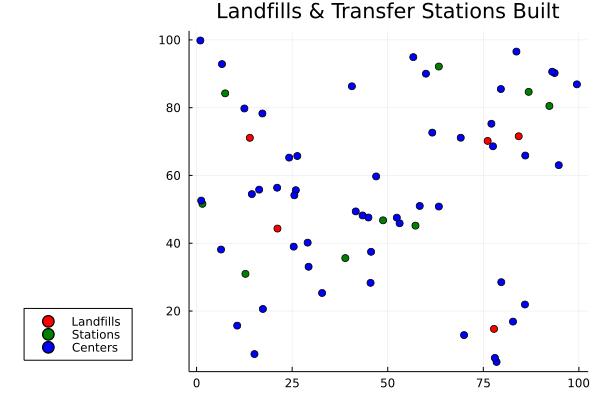

In [283]:
plot(lf_b2.xco, lf_b2.yco, seriestype = :scatter, color = "red", title = "Landfills & Transfer Stations Built",label = "Landfills", legend=:outerbottomleft)
plot!(ts_b2.xco, ts_b2.yco, seriestype = :scatter, color = "green", label = "Stations")
plot!(centers.xco, centers.yco, seriestype = :scatter, color = "blue", label = "Centers")

# B.d
# 9 transfer stations were created. 

In [284]:
round(sum(t))

9.0

# 35.12% of waste in compacted.

In [285]:
x = value.(x);

In [286]:
sum(x)

31665.669999999587

In [287]:
a = value.(a);

In [288]:
sum(a)

17137.500000000487

In [289]:
dist1 = sum(dmat*z1)
dist2 = sum(dmat*z)+sum(dmat_ct*t)+sum(t'*dmat_tl);

# In the first scenario, the total distance traveled was 11,946.95. In the second scenario the total distance significantly increased to 41,153.68 

In [245]:
print(dist1, "  ")

print(dist2)

11946.954019037625  41153.67660407018

# The transportation costs of the first scenario is 840,487.52 and the second scenario is 718,642.75

In [246]:
print(objective_value(mod), " ")
print(objective_value(mod2)-sum(10000*t))

840487.5240012797 718642.7541913444

# The total costs of the first scenario is 840,487.52 and with the transfer stations in the second scenario is 808,642.75.

In [247]:
print(objective_value(mod), " ")
print(objective_value(mod2))

840487.5240012797 808642.7541913458

In [290]:
rename!(centers2,:Column1 => "xco" );
rename!(centers2,:Column2 => "yco" );
rename!(landfills2,:Column1 => "xco" );
rename!(landfills2,:Column2 => "yco" );
rename!(stations2,:Column1 => "xco" );
rename!(stations2,:Column2 => "yco" );
rename!(q2,:Column1 => "waste" );

In [291]:
dmatx = pairwise(Euclidean(), centers2.xco, landfills2.xco);
dmaty = pairwise(Euclidean(), centers2.yco, landfills2.yco);
dmat = sqrt.((dmatx.^2)+(dmaty.^2));

# C.e

In [292]:
mod3 = JuMP.Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(),"MIPGap" => 0.0001))

set_optimizer_attribute(mod2, "OutputFlag", 0) 

#OLD VARIABLES
#if landfill j is built
@variable(mod3, z[j=1:15], Bin)
#amount of waste transported from center i to landfill j
@variable(mod3, x[i=1:40,j=1:15]>=0)

#NEW VARIABLES
#if transfer station s is built
@variable(mod3, t[s=1:50], Bin)
#amount of waste transported from center i to trasnfer station s
@variable(mod3, a[i=1:40,s=1:50]>=0)
#amount of waste transported from center i to trasnfer station s
@variable(mod3, b[s=1:50,j=1:15]>=0)

#OLD CONSTRAINTS
#@constraint(mod3, [i=1:40], sum(x[i,j] for j=1:15)== q[i,1]) modified for reformulation
@constraint(mod3, [i=1:40, j=1:15], x[i,j] <= 1000000*z[j])
@constraint(mod3, sum(z[j] for j=1:15)<=5)

#NEW CONSTRAINTS
#ensure that all waste is taken care of
@constraint(mod3, [i=1:40], sum(x[i,j] for j=1:15) + sum(a[i,s] for s=1:50) == q2[i,1]) 
#conservation of flow for transfer stations
@constraint(mod3, [i=1:40, s=1:50, j=1:15], sum(a[i,s] for i=1:40)==sum(b[s,j] for j=1:15))
#transfer station t cannot serve landfill j unless landfill j is built
@constraint(mod3, [s=1:50, j=1:15], b[s,j] <= 1000000*z[j])
@constraint(mod3, [i=1:40, s=1:50], sum(a[i,s] for i=1:40)<=2000*t[s])



@objective(mod3, Min, sum(dmat[i,j]*x[i,j] for i = 1:40, j = 1:15)
                +    sum(dmat_ct[i,s]*a[i,s] for i = 1:40, s = 1:50)
                +    sum(dmat_tl[s,j]*b[s,j] for s = 1:50, j = 1:15)/2
                +    sum(10000*t[s] for s=1:50))

optimize!(mod3)

Academic license - for non-commercial use only - expires 2022-08-19
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 33391 rows, 3415 columns and 1737315 nonzeros
Model fingerprint: 0x0e70716b
Variable types: 3350 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e-01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+03]
Presolve removed 31900 rows and 0 columns
Presolve time: 0.82s
Presolved: 1491 rows, 3415 columns, 10115 nonzeros
Variable types: 3350 continuous, 65 integer (65 binary)

Root relaxation: objective 9.744086e+05, 243 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 974408.621    0   25          - 974408.621      -     -    0s
H    0     0       

# The daily total cost of region B is $1,076,788.44. 

In [293]:
objective_value(mod3)

1.0767884380013323e6

In [294]:
t = value.(t);
z = value.(z);
i_t = findall(>(.5), t)
i_z = findall(>(.5), z)
ts_b3 = stations2[i_t,:];
lf_b3 = landfills2[i_z,:];

## Transfer Stations are built at the following coordinates:

In [296]:
ts_b3

,xco,yco
,Float64,Float64
1,175.68,65.393
2,133.12,78.404
3,162.59,70.408
4,172.01,96.693
5,158.35,8.6711
6,187.25,64.139
7,127.51,43.675
8,116.65,48.425


## Landfills are built at the following coordinates:

In [297]:
lf_b3

,xco,yco
,Float64,Float64
1,170.73,89.923
2,107.54,70.32
3,130.56,30.882
4,135.89,90.798
5,166.1,61.775


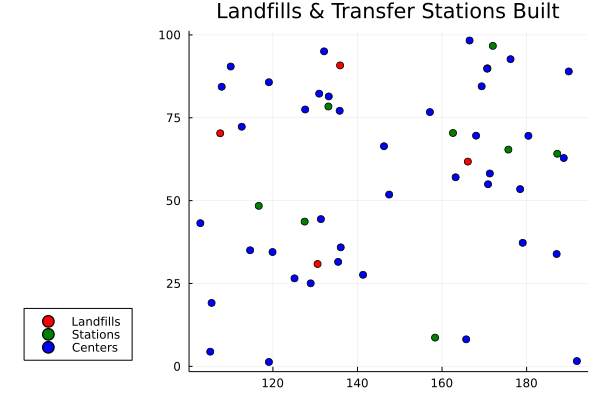

In [295]:
plot(lf_b3.xco, lf_b3.yco, seriestype = :scatter, color = "red", title = "Landfills & Transfer Stations Built",label = "Landfills", legend=:outerbottomleft)
plot!(ts_b3.xco, ts_b3.yco, seriestype = :scatter, color = "green", label = "Stations")
plot!(centers2.xco, centers2.yco, seriestype = :scatter, color = "blue", label = "Centers")

# C.f

In [298]:
append!(stations,stations2);
append!(landfills,landfills2);
append!(centers,centers2);
append!(q,q2);

In [299]:
dmatx = pairwise(Euclidean(), centers.xco, landfills.xco);
dmaty = pairwise(Euclidean(), centers.yco, landfills.yco);
dmat = sqrt.((dmatx.^2)+(dmaty.^2));
dmatx_ct = pairwise(Euclidean(), centers.xco, stations.xco);
dmaty_ct = pairwise(Euclidean(), centers.yco, stations.yco);
dmat_ct = sqrt.((dmatx_ct.^2)+(dmaty_ct.^2));
dmatx_tl = pairwise(Euclidean(), stations.xco, landfills.xco);
dmaty_tl = pairwise(Euclidean(), stations.yco, landfills.yco);
dmat_tl = sqrt.((dmatx_tl.^2)+(dmaty_tl.^2));

In [300]:
print(size(stations), size(landfills), size(centers), size(q))

(100, 2)(30, 2)(90, 2)(90, 1)

In [301]:
mod4 = JuMP.Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(),"MIPGap" => 0.0001))

set_optimizer_attribute(mod4, "OutputFlag", 0) 

#OLD VARIABLES
#if landfill j is built
@variable(mod4, z[j=1:30], Bin)
#amount of waste transported from center i to landfill j
@variable(mod4, x[i=1:90,j=1:30]>=0)

#NEW VARIABLES
#if transfer station s is built
@variable(mod4, t[s=1:100], Bin)
#amount of waste transported from center i to trasnfer station s
@variable(mod4, a[i=1:90,s=1:100]>=0)
#amount of waste transported from center i to trasnfer station s
@variable(mod4, b[s=1:100,j=1:30]>=0)

#OLD CONSTRAINTS
#@constraint(mod4, [i=1:90], sum(x[i,j] for j=1:30)== q[i,1]) modified for reformulation
@constraint(mod4, [i=1:90, j=1:30], x[i,j] <= 1000000*z[j])
@constraint(mod4, sum(z[j] for j=1:30)<=10)

#NEW CONSTRAINTS
#ensure that all waste is taken care of
@constraint(mod4, [i=1:90], sum(x[i,j] for j=1:30) + sum(a[i,s] for s=1:100) == q[i,1]) 
#conservation of flow for transfer stations
@constraint(mod4, [i=1:90, s=1:100, j=1:30], sum(a[i,s] for i=1:90)==sum(b[s,j] for j=1:30))
#transfer station t cannot serve landfill j unless landfill j is built
@constraint(mod4, [s=1:100, j=1:30], b[s,j] <= 1000000*z[j])
@constraint(mod4, [i=1:90, s=1:100], sum(a[i,s] for i=1:90)<=2000*t[s])



@objective(mod4, Min, sum(dmat[i,j]*x[i,j] for i = 1:90, j = 1:30)
                +    sum(dmat_ct[i,s]*a[i,s] for i = 1:90, s = 1:100)
                +    sum(dmat_tl[s,j]*b[s,j] for s = 1:100, j = 1:30)/2
                +    sum(10000*t[s] for s=1:100))

optimize!(mod4)

Academic license - for non-commercial use only - expires 2022-08-19


# The total cost of the combined regions is $1,865,384.50

In [302]:
objective_value(mod4)

1.8653845034414863e6

In [303]:
t = value.(t);
z = value.(z);
i_t = findall(>(.5), t)
i_z = findall(>(.5), z)
ts_b3 = stations[i_t,:];
lf_b3 = landfills[i_z,:];

## Transfer Stations are built at the following coordinates:

In [304]:
ts_b3

,xco,yco
,Float64,Float64
1,85.45,19.15
2,63.366,92.143
3,61.369,50.405
4,83.286,14.437
5,38.906,35.617
6,12.781,30.966
7,48.784,46.765
8,1.5279,51.627
9,7.478,84.236


## Landfills are built at the following coordinates:

In [305]:
lf_b3

,xco,yco
,Float64,Float64
1,76.138,70.191
2,21.163,44.331
3,13.93,71.108
4,171.94,8.2604
5,102.13,78.974
6,170.73,89.923
7,108.11,11.864
8,130.56,30.882
9,135.89,90.798


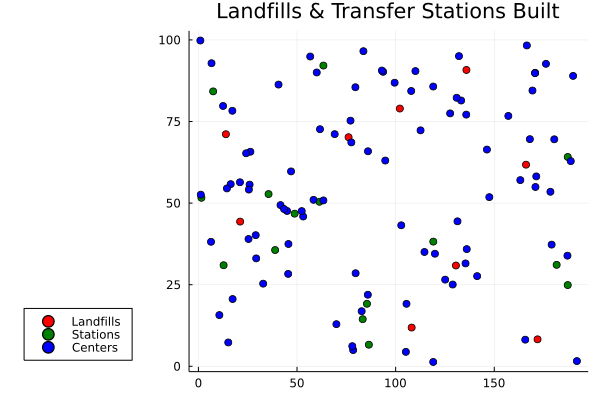

In [306]:
plot(lf_b3.xco, lf_b3.yco, seriestype = :scatter, color = "red", title = "Landfills & Transfer Stations Built",label = "Landfills", legend=:outerbottomleft)
plot!(ts_b3.xco, ts_b3.yco, seriestype = :scatter, color = "green", label = "Stations")
plot!(centers.xco, centers.yco, seriestype = :scatter, color = "blue", label = "Centers")

In [307]:
x=value.(x)

90×30 Matrix{Float64}:
 0.0    0.0   538.56  0.0  0.0  0.0  …  0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0   910.83  0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0   969.95  0.0  0.0  0.0  …  0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0    18.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0  961.35    0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0   955.27  0.0  0.0  0.0  …  0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0   855.61  0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 0.0    0.0     0.0   0.0  0.0  0.0     0.0  0.0  0.0     0.0  0.0     0.0
 ⋮

In [312]:
cl = sum(sum(x[1:50,15:30],dims = 2))

5172.849999999999

In [313]:
cl = sum(sum(x[50:90,1:15],dims = 2))

1033.1